# Data Exploration

In this notebook, we explore the data in the CoverMyMeds Challenge.

In [ ]:
pip install dataframe-image
pip install UpSetPlot

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns
import dataframe_image as dfi
import upsetplot

sns.set_theme(style='whitegrid')

# import utils for loading data
# see `load_tables` in utils.py
import utils

## Load all data

We use the utility function `load_tables` defined in `utils.py` to load all tables.

In [2]:
tables = utils.load_tables()

### dim_date

The `dim_date.csv` contains information about dates ranging from 2017-01-01 to 2021-02-28. These information will be useful for volume forecasting.

In [3]:
df_date = tables['dim_date']
df_date.head(5)

,dim_date_id,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday
0,1,2017-01-01,2017,1,1,1,0,0,1
1,2,2017-01-02,2017,1,2,2,1,0,0
2,3,2017-01-03,2017,1,3,3,1,1,0
3,4,2017-01-04,2017,1,4,4,1,1,0
4,5,2017-01-05,2017,1,5,5,1,1,0


### dim_claims

The `dim_claims.csv` contains pharmacy claims. The columns are as follows.

- **bin**: The BIN of the payer for the claim.
- **drug**: The drug that was associated with the claim.
- **reject_code**: If the claim was rejected, what was the associated rejection code.
- **pharmacy_claim_approved**: Flag for if the claim was approved by the payer.

In [4]:
df_claims = tables['dim_claims']
df_claims.head(5)

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved
0,1,417380,A,75,0
1,2,999001,A,0,1
2,3,417740,A,76,0
3,4,999001,A,0,1
4,5,417740,A,0,1


In [5]:
payers = df_claims.bin.unique().tolist()
print(f'There are {len(payers)} payers: {payers}')

There are 4 payers: ['417380', '999001', '417740', '417614']


In [6]:
drugs = df_claims.drug.unique().tolist()
print(f'There are {len(drugs)} drugs: {drugs}')

There are 3 drugs: ['A', 'B', 'C']


In [7]:
codes = df_claims.reject_code.unique().tolist()
codes = list(filter(None, codes))
print(f'There are {len(codes)} reject codes: {codes}')

There are 3 reject codes: [75, 76, 70]


A code 70 implies that a drug is not covered by the plan and is not on
formulary, and typically implies that another course of therapy should be pursued. A code 75 implies that a drug is on the formulary but does not have preferred status and requires a prior authorization (PA). A PA is a form that care providers submit on behalf of their patient making the case that the therapy as described is a critical course of treatment. A code 76 simply means that the drug is covered, but that the plan limitations have been exceeded, which means that the limitations on the number of fills for that medication has been met. 

In [8]:
df_formulary = df_claims.groupby(
    ['bin', 'drug', 'reject_code']
).size().to_frame(name='reject_count').reset_index()
df_formulary = df_formulary[df_formulary.reject_code != 0].reset_index(drop=True)

df_temp = df_claims.groupby(
    ['bin', 'drug']
).agg(total_count=('reject_code', 'count')).reset_index()

df_formulary = pd.merge(df_formulary, df_temp, on=['bin', 'drug'])
df_formulary['reject_rate'] = np.round(
    df_formulary.reject_count / df_formulary.total_count,
    4
)

df_formulary

,bin,drug,reject_code,reject_count,total_count,reject_rate
0,417380,A,75,88486,88486,1.0000
1,417380,B,76,4419,44371,0.0996
2,417380,C,70,40674,40674,1.0000
3,417614,A,70,156497,156497,1.0000
4,417614,B,75,78686,78686,1.0000
5,417614,C,76,7085,72140,0.0982
6,417740,A,76,10817,108768,0.0995
7,417740,B,70,55035,55035,1.0000
8,417740,C,75,50179,50179,1.0000
9,999001,A,76,32492,325532,0.0998


We conclude that:

1. Each drug in each payer has a fixed reject code.
2. Same drug might have different reject codes in different payers.
3. Drugs with associated reject code 70 or 75 are always get rejected and need prior authorizations.
4. Drugs rejected with code 76 has slightly different reject rates across all payers, but close to 10%.

For example, drug `A` in payer `417380` is always rejected with code 75, meaning that a prior authorization is needed.

**Pharmacies can make good use of this table: when running aganst patients' insurance, they can send PAs if they know that certain drugs are associated with code 70 or 75, with the permission from the patients. It can help the patients to get their treatments quicker.**

### dim_pa

The `dim_pa.csv` contains prior authorizations. The columns are as follows.

- **correct_diagnosis**: Flag for information provided by the provider indicating that the patient has the correct diagnosis for the associated drug.  
- **tried_and_failed**: Flag for information provided by the provider indicating that the patient has tried and failed the relevant generic alternatives.
- **contraindication**: Flag for information provided by the provider indicating that the patient has an associated contraindication for the medication requested. 
- **pa_approved**: Flag for if the payer favorably reviewed and approved the PA.  

In [9]:
df_pa = tables['dim_pa']
df_pa.head(5)

,dim_pa_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved
0,1,1,1,0,1
1,2,1,0,0,1
2,3,0,0,1,1
3,4,1,1,0,1
4,5,0,1,0,1


## Prior Authorization (PA) approved rate

In [10]:
df_pa = tables['dim_pa_full']

df_pa.head(5)

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved,dim_pa_id,dim_date_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday
0,1,417380,A,75,0,1.0,1,1,1,0,1,2017-01-01,2017,1,1,1,0,0,1
2,3,417740,A,76,0,2.0,1,1,0,0,1,2017-01-01,2017,1,1,1,0,0,1
9,10,417380,A,75,0,3.0,1,0,0,1,1,2017-01-01,2017,1,1,1,0,0,1
10,11,999001,A,76,0,4.0,1,1,1,0,1,2017-01-01,2017,1,1,1,0,0,1
14,15,417614,A,70,0,5.0,1,0,1,0,1,2017-01-01,2017,1,1,1,0,0,1


Compared to `dim_pa.csv`, `dim_pa_full` contains all columns from other tables such as `dim_date.csv` and `dim_claims.csv`

In [11]:
def rate(s):
    r = s.sum() / s.count()
    return np.round(r, 4)

pa_target_rate = rate(df_pa.pa_approved)
print(f'The overall PA approved rate is {pa_target_rate:.2%}')

The overall PA approved rate is 73.45%


The target rate of `pa_approved`, or the overall PA approved rate, is as high as 73.45%. It means that a dump model always predicting 1 (indicating the PA is approved) has a good accuracy of 73.45%. We must keep this in mind when trying other models.

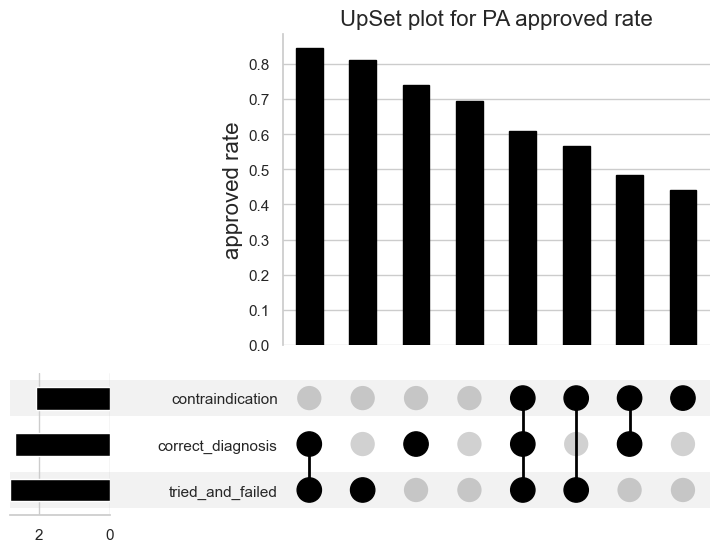

In [12]:
df_patient_group = df_pa.groupby(
    ['correct_diagnosis', 'tried_and_failed', 'contraindication']
    ).agg(
        pa_approved_rate=('pa_approved', rate)
    )

upsetplot.plot(
    df_patient_group.pa_approved_rate,
    sort_by='cardinality',
    element_size=50,
)

plt.title('UpSet plot for PA approved rate', fontsize=16)
plt.ylabel('approved rate', fontsize=16)

plt.savefig('images/pa_upset.png')

plt.show()

The UpSet plot presents to us the PA approved rate for all 8 combinations of **contraindication**, **correct_diagnosis** and **tried_and_failed**. For example, the first vertical bar is the approved rate when **correct_diagnosis** and **tried_and_failed** are both 1. On the other hand, the horizontal bar at the bottom left corner is the sum of approved rates for each flag being 1. For example, the horizontal bar for **contraindication** is the sum of the last four vertical bars.

From the plot, we find that **contraindication** will lower the probability of PA approval. It makes sense, because **contraindication** is a condition that serves as a reason to not take a certain medical treatment due to the harm that it would cause the patient <sup>[[wiki]](https://en.wikipedia.org/wiki/Contraindication)</sup>. On the contrary, **correct_diagnosis** and **tried_and_failed** increase the chance of approval.

## Volume of Prior Authorizations

In [13]:
# Get months' names
month_names = (
    pd
    .date_range('2021-01-01', periods=12, freq='M')
    .month_name()
    .str[:3]
    .tolist()
)


print(month_names)

['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


In [14]:
# Get monthly volumne of PAs
df_pa_month = (
    df_pa
    .groupby(['calendar_year', 'calendar_month'])
    .size()
    .to_frame(name='pa')
    .reset_index()
    .rename(columns={'calendar_year': 'year', 'calendar_month': 'month'})
)

# Add numbers of days, weekdays, workdays and holidays
df_temp = (
    tables['dim_date']
    .groupby(['calendar_year', 'calendar_month'])
    .agg(
        days=('calendar_day', 'count'),
        weekdays=('is_weekday', 'sum'),
        workdays=('is_workday', 'sum'),
        holidays=('is_holiday', 'sum')
    )
    .reset_index()
    .rename(
        columns={
            'calendar_year': 'year',
            'calendar_month': 'month'
        }
    )
)

df_pa_month = pd.merge(df_pa_month, df_temp, on=['year', 'month'], how='left')

# move pa to the last column
cols = df_pa_month.columns.to_list()
cols.remove('pa')
cols.append('pa')
df_pa_month = df_pa_month[cols]

df_pa_month.head(5)

,year,month,days,weekdays,workdays,holidays,pa
0,2017,1,31,22,21,1,13766
1,2017,2,28,20,20,0,12769
2,2017,3,31,23,23,0,14694
3,2017,4,30,20,20,0,12742
4,2017,5,31,23,22,1,13717


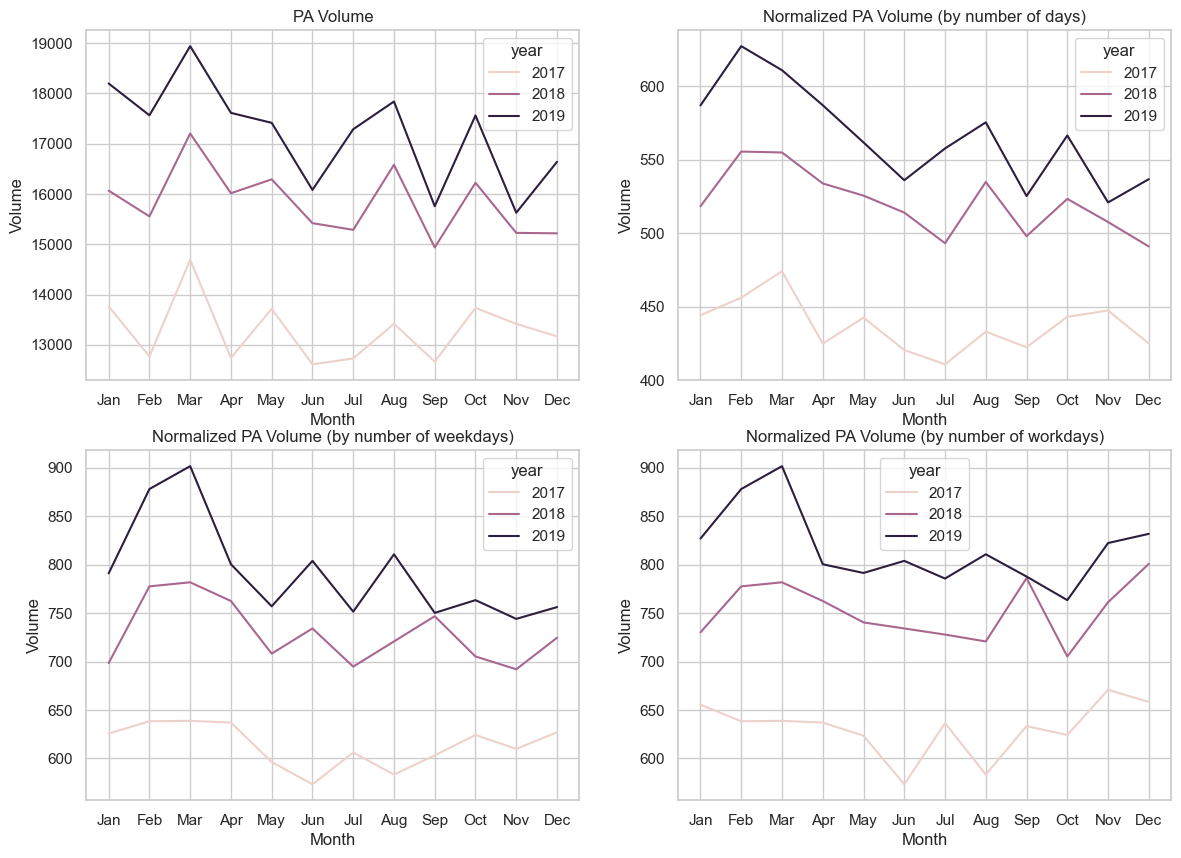

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

for a in ax.flatten():
    a.set_xticks(range(1, 13))
    a.set_xticklabels(month_names)
    a.set_xlabel('Month')
    a.set_ylabel('Volume')

sns.lineplot(x='month', y='pa', data=df_pa_month, hue='year', ax=ax[0, 0])
ax[0, 0].set_title('PA Volume')

normalized_pa = df_pa_month.pa / df_pa_month.days
sns.lineplot(x=df_pa_month.month, y=normalized_pa, hue=df_pa_month.year, ax=ax[0, 1])
ax[0, 1].set_title('Normalized PA Volume (by number of days)')

normalized_pa = df_pa_month.pa / df_pa_month.weekdays
sns.lineplot(x=df_pa_month.month, y=normalized_pa, hue=df_pa_month.year, ax=ax[1, 0])
ax[1, 0].set_title('Normalized PA Volume (by number of weekdays)')

normalized_pa = df_pa_month.pa / df_pa_month.workdays
sns.lineplot(x=df_pa_month.month, y=normalized_pa, hue=df_pa_month.year, ax=ax[1, 1])
ax[1, 1].set_title('Normalized PA Volume (by number of workdays)')

plt.savefig('images/pa_monthly_volume_expore.png')
plt.show()

Visualizing the four plots side by side, it seems that normalized PA volume by number of weekdays shows better pattern within a year. We can better visualize the pattern using a polar plot.

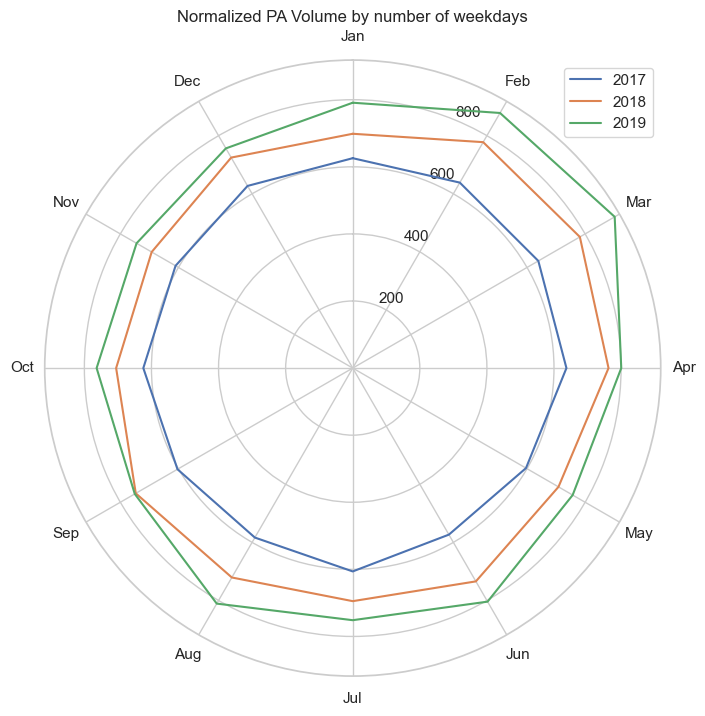

In [16]:
normalized_factor = 'weekdays'
df_pa_month['normalized_pa'] = df_pa_month.pa / df_pa_month[normalized_factor]

plt.figure(figsize=(8, 8))

ax = plt.subplot(projection='polar')
tickers = np.linspace(0, 2 * np.pi, 12, endpoint=False)
ax.set_xticks(tickers)
ax.set_xticklabels(month_names)
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2)

data = df_pa_month.groupby('year').agg(volume=('normalized_pa', list))
rtickers = tickers.tolist() + [tickers[0]]
for year, volumes in zip(data.index, data.volume):
    volumes.append(volumes[0])
    plt.plot(rtickers, volumes, label=f'{year}')

plt.title(f'Normalized PA Volume by number of {normalized_factor}')
plt.legend()
plt.show()

As years went by, the circle of volumes expanded. It indicates that there is an increasing trend in volume over the years. 

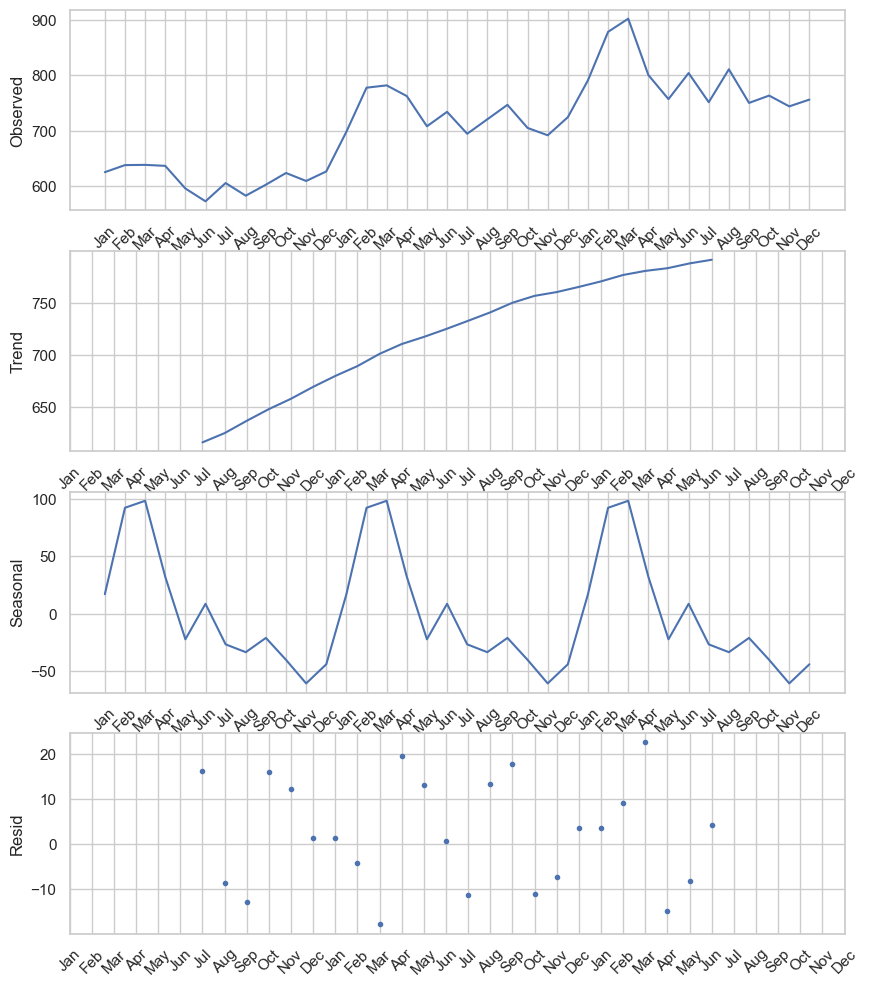

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_pa_month.normalized_pa, model='add', period=12)

fig, axes = plt.subplots(4, 1, figsize=(10, 12))

# observed
result.observed.plot(ax=axes[0], legend=False, ylabel='Observed')

# Trend
result.trend.plot(ax=axes[1], legend=False, ylabel='Trend')

# Seasonal
result.seasonal.plot(ax=axes[2], legend=False, ylabel='Seasonal')

# Resid
result.resid.plot(ax=axes[3], legend=False, ylabel='Resid', style='.')

for ax in axes:
    ax.set_xticks(range(36))
    ax.set_xticklabels(month_names * 3, rotation=45)

plt.show()

Using the `seasonal_decompose` from `statsmodels`, we discover that there is a surge of volume in the begining of the year until March, then the volume gradually drops til the end of the year.